<a href="https://www.kaggle.com/code/aysegulsezen/notebook308394dd5c?scriptVersionId=176866475" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        fileFullName=os.path.join(dirname, filename)
        if (filename=='training.zip'):
            train_data = pd.read_csv(fileFullName,compression='zip')
        elif (filename=='test.zip'):
            test_data = pd.read_csv(fileFullName,compression='zip') #pd.read_csv(fileFullName)
        elif (filename=='IdLookupTable.csv'):
            IdLookupTable_data = pd.read_csv(fileFullName)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


# ANALYSING DATA
First, let's understand the data again. The first 30 columns show certain coordinates on the human face. According to a 96x96 image, the coordinates are determined as horizontal and vertical (x,y). The image pixel information given in the last column is given as a single string data and each pixel is separated by spaces. It will be necessary to separate this with split.Let's show the first image and coordinates on it.



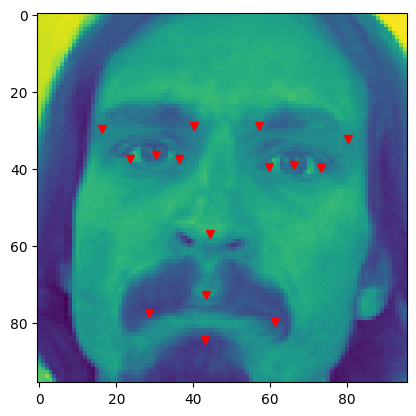

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

X = train_data['Image'] 
y = train_data.iloc[:,:30].values

st = X[0].split(' ')
st2=[float(i) for i in st]

for i in range(0,15):
    plt.plot(y[0,i*2], y[0,(i*2)+1], marker='v', color="red") 

plt.imshow( np.reshape(st2,(96,96)))


Preparing data. Making matrix from image pixels.

# Finding and changing missing points
According to the dataset description, there are some missing fields in the training data. We should always check the training data. 
"In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas)"

Before spliting all training and test data, we need to find the missing fields and decide what to do.

y: 7049
missing images count : (4909,)
missing point name1: mouth_center_bottom_lip_x
missing point name2: mouth_center_bottom_lip_y
X count: (2140,)
y count: (2140, 30)


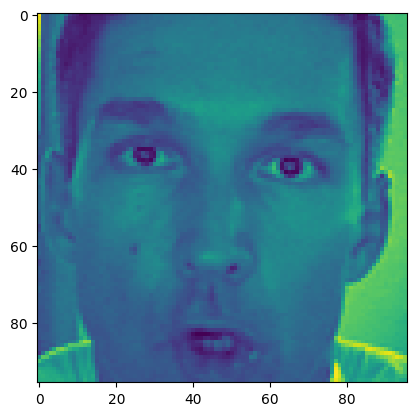

In [3]:
import math
missing_elements = []
print('y:',y.shape[0])
for x1 in range(0,y.shape[0]):
    for y1 in range(0,30):
        try:
            if  math.isnan(float(y[x1,y1])):
                missing_elements.append([x1,y1])
        except:
            missing_elements.append([x1,y1])

missing_images_no=np.unique( np.array(missing_elements)[:,0])
print('missing images count :',missing_images_no.shape)

column_name = list(train_data.columns)
column_name1 = column_name.remove('Image')

#print('column_name',column_name[0])

missing_image=[]
ele_prv=[0,0]
for ele in missing_elements[0:10]:
    if ele_prv[0] == ele[0]:
        missing_image.append([ele[0],[ele_prv[1],ele[1]]])
    ele_prv=ele

imageNo=missing_image[0][0]
    
print('missing point name1:',column_name[missing_image[0][1][0]])
print('missing point name2:',column_name[missing_image[0][1][1]])
st = X[imageNo].split(' ')
st2=[float(i) for i in st]
plt.imshow( np.reshape(st2,(96,96)))

# Dropping images of missing values
X=np.delete(X, missing_images_no, axis=0)
y=np.delete(y, missing_images_no, axis=0)

print('X count:',X.shape)
print('y count:',y.shape)

Should we delete the entire row because it has a missing field? If we do it this way, the training data with 7049 lines decreases to 2140 lines. This means that we can train the neural network with 2140 images. This may reduce accuracy. Above is an example of an image with missing fields. mouth_center_bottom_lip_x and mouth_center_bottom_lip_y fields are missing. Probably the people who entered the data could not determine the exact coordinates of the mouth center and left it blank. We can find the ratio of eye and mouth coordinates in other pictures and fill in the missing areas in these pictures approximately. But for now, I first want to delete these lines completely and see what happens with the accurcy with the 2140 images.

rowCount 2140
X_arr: (2140, 9216)
y: (2140, 30)
X_test_arr: (1783, 9216)
img: (2140, 96, 96, 1)
img_test: (1783, 96, 96, 1)


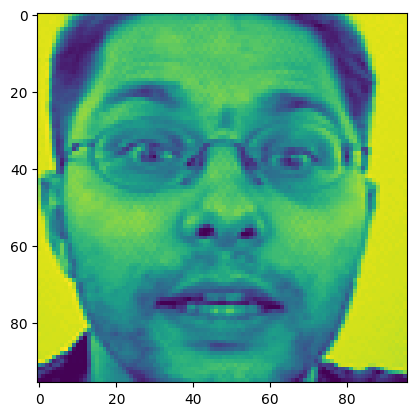

In [4]:
import numpy as np

X_test = test_data['Image']

rowCount= X.shape[0] 
print('rowCount',rowCount)

X_arr=np.zeros(shape=(rowCount,9216))
X_test_arr=np.zeros(shape=(X_test.shape[0],9216))
img=[]
img_test=[]

for i in range(rowCount):
    st = X[i].split(' ')
    X_arr[i,:]=st
    img2= np.reshape(st, (96, 96,1)).astype(float) 
    img.append( img2 )

for i in range(X_test.shape[0]):
    st_test= X_test[i].split(' ')
    X_test_arr[i,:]=st_test
    img1= np.reshape(st_test, (96, 96,1)).astype(float)  
    img_test.append( img1 ) 

print('X_arr:',X_arr.shape)
print('y:',y.shape)

print('X_test_arr:',X_test_arr.shape)

plt.imshow( img[0])
print('img:',np.array(img).shape)

plt.imshow( img_test[0])
print('img_test:',np.array(img_test).shape)



We can use neural network to make predictions with this data. Input units are pixel of images. Keras accept images(96x96) as input. Outputs are 30 keypoints of image. It is not classification. Activation function shouldn't be sigmoid or softmax. Our output values shouldn't be negative. So Relu function all of them will be suitable. Loss function absolute_mean_error is good. Results of prediction should be between 0-96. Relu function all of them give correct output format.

Finding good accuracy, we should try it with train and validation data. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

X_train, X_val, y_train, y_val = train_test_split(np.array(img), y, test_size=0.25, random_state=1)

model = Sequential()
    
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(96,96,1)))
model.add(MaxPooling2D())
    
model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())
    
model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())
    
model.add(Flatten())
    
model.add(Dense(128,activation='relu'))
#model.add(Dense(64,activation='relu')) #when I add this line (new hidden layer), acc reduce 63 
model.add(Dense(30,activation='relu'))
#loss func is categorical_crossentropy, acc is 59.88; but mean_absolute_error acc:64.08
model.compile('adam',loss='mean_absolute_error',metrics=['accuracy'])

model.summary()
hist=model.fit( X_train,y_train ,epochs=20)

y_pred=model.predict(X_val)

2024-05-10 15:57:05.246016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 15:57:05.246190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 15:57:05.392619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,222 (852.43 KB)

 Trainable params: 218,222 (852.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.0532 - loss: 25.8429
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.5369 - loss: 15.2693
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6630 - loss: 14.4746
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6106 - loss: 14.5678 
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6374 - loss: 13.0889
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6188 - loss: 12.7838 
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6630 - loss: 13.1294
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6695 - loss: 12.4154
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.6871 - loss: 12.2074
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6919 - loss: 12.0176
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.6808 - loss: 11.7678
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 99

In [6]:
print(sum(abs(y_pred[0]- y_val[0])))
print(' ',y_pred[0][4],' :',y_val[0][4])
print(np.stack((y_pred[0], y_val[0])).transpose() )

score = model.evaluate(X_val, y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

314.2647257070922
  0.0  : 59.8870943396
[[69.98365784 66.40120755]
 [ 0.         39.89675472]
 [30.86145401 28.67441509]
 [39.92546463 36.36830189]
 [ 0.         59.88709434]
 [42.81461716 40.71064151]
 [77.73848724 73.72920755]
 [42.77905655 41.52513208]
 [39.09950638 35.45962264]
 [41.39699554 37.99667925]
 [ 0.         21.88920755]
 [40.3587265  36.63939623]
 [60.08691788 60.15818868]
 [33.55712128 29.31133585]
 [84.21928406 82.14279245]
 [34.59269714 33.38264151]
 [41.21086502 40.34535849]
 [30.79239655 28.49714717]
 [ 0.         15.64618868]
 [ 0.         27.41144151]
 [49.75063324 47.13056604]
 [ 0.         60.52407547]
 [63.32854462 57.71592453]
 [87.90692139 84.67984906]
 [ 0.         32.47396226]
 [84.84801483 83.86596226]
 [48.61577606 46.31607547]
 [80.64867401 79.79471698]
 [48.9709053  46.31607547]
 [93.16201782 93.09403774]]
Val loss: 12.322700500488281
Val accuracy: 0.7084112167358398


The 68% accuracy rate is not enough to build important work on this work. It needs to be more than 90%. When we add a hidden layer or change the parameters, the accuracy rate increases to 70% at most. Maybe we need to investigate different parameters. Increasing training data may also be a solution. A solution may be to not delete the 4909 images we have deleted and fill in the missing fields proportionally.

In [7]:
y_pred = model.predict(np.array(img_test))

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


In [8]:
#IdLookupTable_data
print(IdLookupTable_data)
dfP=pd.DataFrame(columns=['RowId','ImageId','FeatureName','Location'])

rowNo=0
for x1 in range(y_pred.shape[0]):
    for y1 in range(y_pred.shape[1]):
         new_row = {"RowId":rowNo,
                    "ImageId": test_data.iloc[x1][0],
                    "FeatureName": column_name[y1],
                    "Location":y_pred[x1,y1]/1000                  
                   }
         dfP=pd.concat([dfP, pd.DataFrame([new_row])], ignore_index=False)
         rowNo=rowNo+1
print('df shape:',dfP.shape)
print('dfP:')
print(dfP)

df = pd.merge( IdLookupTable_data,dfP, how="inner", on=["ImageId","FeatureName"])

print(df.shape)
print(df)

       RowId  ImageId                FeatureName  Location
0          1        1          left_eye_center_x       NaN
1          2        1          left_eye_center_y       NaN
2          3        1         right_eye_center_x       NaN
3          4        1         right_eye_center_y       NaN
4          5        1    left_eye_inner_corner_x       NaN
...      ...      ...                        ...       ...
27119  27120     1783         right_eye_center_y       NaN
27120  27121     1783                 nose_tip_x       NaN
27121  27122     1783                 nose_tip_y       NaN
27122  27123     1783  mouth_center_bottom_lip_x       NaN
27123  27124     1783  mouth_center_bottom_lip_y       NaN

[27124 rows x 4 columns]


/tmp/ipykernel_18/1564025131.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "ImageId": test_data.iloc[x1][0],
/tmp/ipykernel_18/1564025131.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfP=pd.concat([dfP, pd.DataFrame([new_row])], ignore_index=False)


df shape: (53490, 4)
dfP:
    RowId ImageId                FeatureName  Location
0       0       1          left_eye_center_x  0.059891
0       1       1          left_eye_center_y  0.000000
0       2       1         right_eye_center_x  0.025258
0       3       1         right_eye_center_y  0.032063
0       4       1    left_eye_inner_corner_x  0.000000
..    ...     ...                        ...       ...
0   53485    1783       mouth_right_corner_y  0.049329
0   53486    1783     mouth_center_top_lip_x  0.028829
0   53487    1783     mouth_center_top_lip_y  0.048277
0   53488    1783  mouth_center_bottom_lip_x  0.031534
0   53489    1783  mouth_center_bottom_lip_y  0.051466

[53490 rows x 4 columns]
(27124, 6)
       RowId_x ImageId                FeatureName  Location_x RowId_y  \
0            1       1          left_eye_center_x         NaN       0   
1            2       1          left_eye_center_y         NaN       1   
2            3       1         right_eye_center_x         

In [9]:
df.drop(['ImageId','FeatureName','Location_x','RowId_y'], axis=1, inplace=True)
df = df.rename(columns={'RowId_x': 'RowId', 'Location_y': 'Location'})
print(df)

       RowId  Location
0          1  0.059891
1          2  0.000000
2          3  0.025258
3          4  0.032063
4          5  0.000000
...      ...       ...
27119  27120  0.024057
27120  27121  0.031192
27121  27122  0.000000
27122  27123  0.031534
27123  27124  0.051466

[27124 rows x 2 columns]


In [10]:
df.to_csv('/kaggle/working/predictAysegulFace4.csv',index=False)